In [1]:
import numpy as np
from scipy.linalg import null_space, inv, expm
from low_pass_filter import LTISystem
import matplotlib.pyplot as plt
import control
from l1_adaptive_controller import L1_adapt

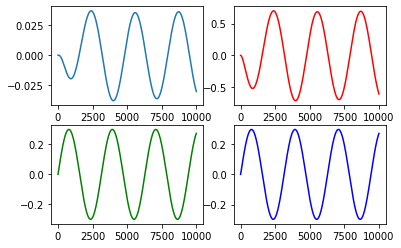

In [23]:

def f(x):
    Am = np.array([[0, 1, 0, 0], [0, 0, 0, -9.8],
                  [0, 0, 0, 32.667], [0, 0, 1, 0]])
    return np.matmul(Am, x)


def g(x):
    Bm = np.array([[0, 2, -3.33, 0]]).T
    return Bm


def lqr_policy(observation):

    Q = np.identity(4)
    R = np.identity(1)

    # linearization
    A = np.array([[0, 1, 0, 0], [0, 0, 0, -9.8],
                 [0, 0, 0, 32.667], [0, 0, 1, 0]])

    B = np.array([[0, 2, -3.33, 0]]).T

    K, S, E = control.lqr(A, B, Q, R)

    action = -K@observation

    if action >= 1:
        return np.array([[1]])
    elif action <= -1:
        return np.array([[-1]])
    else:
        return action


adaptive_controller = L1_adapt(f, g)
observation = np.zeros((4, 1))
obs_list = []
policy = []
true_uncertainty = []
est_uncertainty = []

for _ in range(10000):

    u_bl = lqr_policy(observation)

    u = adaptive_controller.get_control_input(observation, u_bl)

    observation = adaptive_controller.plant(observation, u)

    obs_list.append(observation[3])
    policy.append(u.squeeze(0))
    (sigma_m,sigma_um), (sigma_hat_m,sigma_hat_um) = adaptive_controller.get_uncertainty()
    true_uncertainty.append(sigma_m.squeeze(0))

    est_uncertainty.append(sigma_hat_m.squeeze(0).squeeze(0)[()])

t = np.arange(10000)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(t, obs_list)
axs[0, 1].plot(t, policy, 'r')
axs[1, 0].plot(t, true_uncertainty, 'g')
axs[1, 1].plot(t, est_uncertainty, 'b')




In [2]:
def f(x):
     Am = np.array([[0,1,0,0],[0,0, 0, -9.8],[0, 0, 0, 32.667],[0, 0, 1, 0]])
     return np.matmul(Am,x)

def g(x):
    Bm = np.array([[0,2,-3.33,0]]).T
    return Bm




def lqr_policy(observation):

    Q = np.identity(4)
    R = np.identity(1)

    # linearization
    A = np.array([[0,1,0,0],[0,0, 0, -9.8],[0, 0, 0, 32.667],[0, 0, 1, 0]])

    B = np.array([[0,2,-3.33,0]]).T

    K, S, E = control.lqr(A,B,Q,R)

    action = -K@observation


    if action >= 1:
        return np.array([[1]])
    elif action <=-1:
        return np.array([[-1]])
    else:
        return action


adaptive_controller = L1_adapt(f,g)
observation=np.zeros((4,1))
obs_list=[]
policy=[]
true_uncertainty = []
est_uncertainty = []

for _ in range(20000):
    
    u_bl= lqr_policy(observation)

    # u=adaptive_controller.get_control_input(observation,u_bl)
    
    observation=adaptive_controller.plant(observation,u_bl)
    
    obs_list.append(observation[3])
    policy.append(u_bl.squeeze(0))
    



In [11]:
def f(x):
     Am = np.array([[0,1,0,0],[0,0, 0, -9.8],[0, 0, 0, 32.667],[0, 0, 1, 0]])
     return np.matmul(Am,x)

def g(x):
    Bm = np.array([[0,2,-3.33,0]]).T
    return Bm




def lqr_policy(observation):

    Q = np.identity(4)
    R = np.identity(1)

    # linearization
    A = np.array([[0,1,0,0],[0,0, 0, -9.8],[0, 0, 0, 32.667],[0, 0, 1, 0]])

    B = np.array([[0,2,-3.33,0]]).T

    K, S, E = control.lqr(A,B,Q,R)

    action = -K@observation


    if action >= 1:
        return np.array([[1]])
    elif action <=-1:
        return np.array([[-1]])
    else:
        return action


adaptive_controller = L1_adapt(f,g)
observation=np.zeros((4,1))
obs_list=[]
policy=[]

for _ in range(1000):
    
    u_bl= lqr_policy(observation)

    u=adaptive_controller.get_control_input(observation,u_bl)
    
    observation=adaptive_controller.plant(observation,u)
    
    obs_list.append(observation[3])
    policy.append(u.squeeze(0))
    



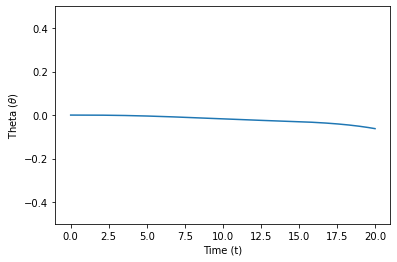

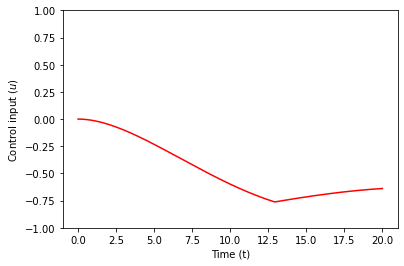

In [12]:
t = np.linspace(0,20,1000)
plt.plot(t,obs_list)
plt.ylim((-0.5,0.5))
plt.xlabel(r'Time (t)')
plt.ylabel(r'Theta ($\theta$)')
plt.show()
plt.plot(t,policy,'r')
plt.ylim((-1,1))
plt.xlabel(r'Time (t)')
plt.ylabel(r'Control input ($u$)')
plt.show()


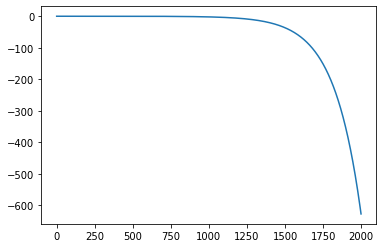

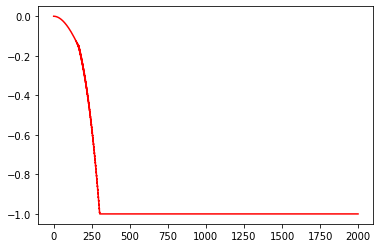

In [37]:
import numpy as np
from scipy.linalg import null_space, inv, expm
from low_pass_filter import LTISystem
import matplotlib.pyplot as plt
import control

class L1_adapt(object):

    def __init__(self,f,g,wc=10,Ts=0.001):
        '''
        xdot = f(x) + g(x)u (control-affine structure)
        f: mapping from state space to state space (R^n)
        g: mapping from state space to R^(n x m) such that g(x)u makes R^n
        wc: cutoff frequency used in lowpass filter
        Ts: sampling time used in piece-wise continuous adaptation law
        '''
        #plant
        self.f = f
        self.g = g
        self.g_perp = lambda x : null_space(self.g(x).T)
        self.time = 0
    
        #low pass filter
        self.wc = wc # cutoff frequency
        self.Ts = Ts # sampling period
        self.dt = 2*self.wc*self.Ts #low pass filter. Normalizing filtering frequency
        self.lpf=LTISystem(A=np.array([-self.wc]),B=np.array([1]),C=np.array([self.wc]))         

        # Initialization of state, error and input vectors 
        self.x = np.zeros((4,1)) 
        self.x_tilde = np.zeros((4,1))
        self.u = np.zeros((1,1))
        self.n = self.g(self.x).shape[0]
        self.m = self.g(self.x).shape[1]


        # Initialize parameters needed for L1 controller
        self.As = -1*np.eye(self.n) # Choice of Hurwitz matrix used in piece-wise constant adaptation
        self.x_hat = np.zeros(shape = (self.n,1)) # Initialization of predicted state vector

    
    def update_error(self):
        return self.x_hat-self.x
    
    
    def plant(self,x,u):
        sigma_m = 0.5*np.sin(self.time)
        sigma_um = np.zeros((3,1))
        x_dot = self.f(x)+self.g(x)@(u+sigma_m) + self.g_perp(x)@(sigma_um)
        x_next = x + x_dot*self.Ts
        self.time += self.Ts
        
        return x_next

    def adaptive_law(self,x_tilde):
        
        mat_expm = expm(self.As*self.Ts)
        Phi = inv(self.As) * (mat_expm - np.eye(self.n))
        adapt_gain = -inv(Phi)*mat_expm

        gg = np.concatenate((self.g(self.x),self.g_perp(self.x)),axis=1) #[g,g_perp]
        
        sigma_hat = inv(gg) @ adapt_gain @ x_tilde
        sigma_hat_m = sigma_hat[:self.m] 
        sigma_hat_um = sigma_hat[self.m:]

        return sigma_hat_m,sigma_hat_um

    
    def state_predictor(self,x,u,sigma_hat_m,sigma_hat_um):

        x_hat_dot = self.f(x)+self.g(x)@(u+sigma_hat_m)+np.matmul(self.g_perp(x),sigma_hat_um)+np.matmul(self.As,self.x_tilde)
        x_hat = x + x_hat_dot*self.Ts #Euler extrapolation
        return x_hat

    def get_control_input(self,x,u_bl):

        sigma_hat_m, sigma_hat_um = self.adaptive_law(self.x_tilde)
        u_l1=self.lpf.get_next_state(sigma_hat_m,self.dt)

        u=u_bl+u_l1

        if u >= 1:
            u=np.array([[1]])
        elif u <=-1:
            u=np.array([[-1]])

        self.x = self.plant(x, u)
        self.x_hat = self.state_predictor(x,u,sigma_hat_m, sigma_hat_um)
        self.x_tilde = self.update_error()

        return u


def f(x):
     Am = np.array([[0,1,0,0],[0,0, 0, -9.8],[0, 0, 0, 32.667],[0, 0, 1, 0]])
     return np.matmul(Am,x)

def g(x):
    Bm = np.array([[0,2,-3.33,0]]).T
    return Bm




def lqr_policy(observation):

    Q = np.identity(4)
    R = np.identity(1)

    # linearization
    A = np.array([[0,1,0,0],[0,0, 0, -9.8],[0, 0, 0, 32.667],[0, 0, 1, 0]])

    B = np.array([[0,2,-3.33,0]]).T

    K, S, E = control.lqr(A,B,Q,R)

    action = -K@observation


    if action >= 1:
        return np.array([[1]])
    elif action <=-1:
        return np.array([[-1]])
    else:
        return action


adaptive_controller = L1_adapt(f,g)
observation=np.zeros((4,1))
obs_list=[]
policy=[]

for _ in range(2000):
    
    u_bl= lqr_policy(observation)

    u=adaptive_controller.get_control_input(observation,u_bl)
    
    observation=adaptive_controller.plant(observation,u)
    
    obs_list.append(observation[3])
    policy.append(u_bl.squeeze(0))


plt.plot(np.arange(2000),obs_list)
plt.show()
plt.plot(np.arange(2000),policy,'r')
plt.show()
